# Testing NS_dynamics code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py
import os
import matplotlib.animation as animation

plt.rcParams['axes.grid'] = True
plt.style.use('dark_background')

In [2]:
# Constants defined 
G = 6.67259e-11  # (km**3/kg/s**2)
c= 3e8 #m/sec
Ms = 1.98847e30 # solar mass in kg

d = 1.5e11
ev = (2*3.14159*d/(365*24*60*60)) 

In [3]:
# import from other files 
from ipynb.fs.full.Neutron_Star_SPH_sph import W, gradW, getPairwiseSeparations, getDensity
from ipynb.fs.full.Neutron_Star_SPH_eos import *
from ipynb.fs.full.Neutron_Star_SPH_NS import *
from ipynb.fs.full.NS_dynamics import *

In [4]:
myEOS = EOS(name='standard') # create an equation of state object

myNS = NS("my Neutron star 1", myEOS,1,0.5)
myNS2 = NS("my Neutron star 2", myEOS,2,1) # double the mass and radius of the first star

-------success!
 
STAR OBJECT. Name: 'my Neutron star 1', Mass: 1 SMs, Radius: 0.5 km 

-------success!
 
STAR OBJECT. Name: 'my Neutron star 2', Mass: 2 SMs, Radius: 1 km 



Stars are created. Now for motion. 

## galaxy collision

In [4]:
l = [[0,0,0],[2,2,2]]
l[0,:]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
# 
def acceleration(pos1,pos2, ns1, ns2):
    pos = [pos1,pos2]
    mass = [ns1.get(masses), ns2.get(masses)]
    acc = np.zeros(pos.shape)
    n = pos.shape[0]
    for i in range(n):
        for j in range(n):
            if j != i:
                vector = pos[j, :] - pos[i, :]
                distance = np.linalg.norm(vector)
                if distance != 0:
                    acc[i, :] += (G * massesM[j] * vector) / (distance + self.softLength) ** 3
    return massesA


def compute(ns1, ns2, dt):
    # Calculating new positions
    # method='RUNGE_KUTTA'
    k1_X = ns1.vel * dt
    k1_V = self.acceleration(self.massesX, self.massesM) * dt
    k2_X = (self.massesV + k1_V / 2) * dt
    k2_V = self.acceleration(self.massesX + k1_X / 2, self.massesM) * dt
    k3_X = (self.massesV + k2_V / 2) * dt
    k3_V = self.acceleration(self.massesX + k2_X / 2, self.massesM) * dt
    k4_X = (self.massesV + k3_V) * dt
    k4_V = self.acceleration(self.massesX + k3_X, self.massesM) * dt
    # Updating positions
    newX = self.massesX + (k1_X + 2 * k2_X + 2 * k3_X + k4_X) / 6
    newV = self.massesV + (k1_V + 2 * k2_V + 2 * k3_V + k4_V) / 6
    self.massesX = newX
    self.massesV = newV
    
    
def run(ns1, ns2, dt=0.1, T=10):
    step, limit = 0, int(T / dt)
    # MAIN LOOP
    for step in range(limit):
        # Computation
        compute(ns1, ns2, dt)

In [ ]:
def forces(pos):
        width = abs(pos[0]-pos[1])
        vector = self.centreMassX - position
        distance = np.sqrt(vector[0] ** 2 + vector[1] ** 2 + vector[2] ** 2)
        if distance != 0:
            ratio = width / distance
            if ratio < self.theta or self.allNoneChildren():
                acceleration = (self.gravitationCst * self.centreMass * vector) / (distance + self.softLength) ** 3
                return acceleration
            else:
                acceleration = np.array([0.0, 0.0, 0.0])
                for i in self.children:
                    if isinstance(i, OctTree) and i.nbObjects != 0:
                        acceleration += i.forces(position)
                return acceleration
        else:
            return np.array([0, 0, 0])

## Glowscript trinket
https://trinket.io/glowscript/fbb84e900c

In [175]:
ns1 = myNS
ns2 = myNS2 
sep =10002

#def orbit(ns1, ns2, sep):
m1=ns1.get_mass()*Ms
m2=ns2.get_mass()*Ms
rdist=sep
M=m1+m2

r1=m2*rdist/(M)
r2=rdist*(1-m2/M)
p1 = np.array([-r1,0])
p2 = np.array([r2,0])

t=0
dt=1000
tend = 1e5
i = 0
N = int(tend/dt)

Rcom=np.zeros([N,2])
Rcom[0]=(m1*p1+m2*p2)/M

mom1=np.zeros([N,2])
mom2 = np.zeros([N,2])
mom1[0] = m1*np.array([0,np.sqrt(G*m2**2/(rdist*M))])
mom2[0] = -1*mom1[0]

pos1=np.zeros([N,2])
pos2=np.zeros([N,2])
pos1[0] = p1
pos2[0] = p2

while t<(tend-dt):
    i = i+1
    r=pos2[i-1]-pos1[i-1]
    F2=-G*m1*m2*r/(np.linalg.norm(r)**3)
    mom1[i]=mom1[i-1]-F2*dt
    mom2[i]=mom2[i-1]+F2*dt
    pos1[i]=pos1[i-1]+mom1[i]*dt/m1
    pos2[i]=pos2[i-1]+mom2[i]*dt/m2
    Rcom[i]=(m1*pos1[i]+m2*pos2[i])/M
    t=t+dt
#return pos1, pos2, Rcom

In [176]:
pos2[0]-pos1[0]

array([10002.,     0.])

In [170]:
np.sqrt(G*m2**2/(rdist*M))*m1

9.349014999006115e+37

In [155]:
p1, p2, rcm = orbit(myNS, myNS2, 10000)

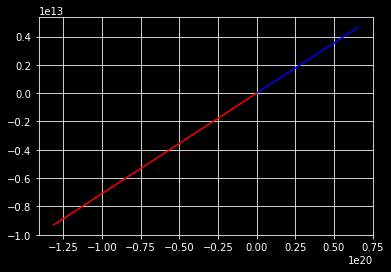

In [177]:
plt.plot(pos1[:,0], pos1[:,1], c='blue')
plt.plot(pos2[:,0], pos2[:,1], c='red')

In [133]:
pos1[10]

array([1.64847698e+10, 3.31816005e+09, 0.00000000e+00])

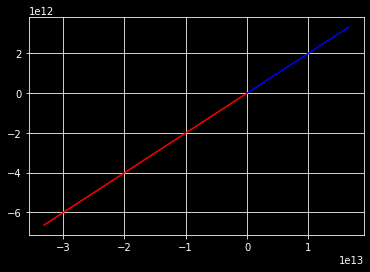

In [92]:
plt.plot(pos1[:,0], pos1[:,1], c='blue')
plt.plot(pos2[:,0], pos2[:,1], c='red')

In [ ]:
plt.figure(figsize=(8,8))
for n, planet in enumerate(Bodies): 
    px, py=np.array(paths[n]).T; 
    plt.plot(px, py, color=planet.color, lw=planet.lw)
plt.show()

## odeint integration

In [ ]:
def two_body_eqm(_y, _t, _G, _m1, _m2):
    """
    differential equations of motion describing the two-body-problem
    _t: discrete time step value
    _y: state vector
    """
    # magnitude of position vector from r1 to r2
    r_mag = np.linalg.norm(_y[3:6] - _y[:3])
    c0 = _y[6:12]
    c1 = _G * _m2 * ((_y[3:6] - _y[:3]) / np.power(r_mag, 3))
    c2 = _G * _m1 * ((_y[:3] - _y[3:6]) / np.power(r_mag, 3))
    return np.concatenate((c0, c1, c2))

# ==============================================================
# simulation harness


# time array
time = np.arange(0, 480, 0.5)

# body m1 initial conditions
m1 = 1e26  # mass (kg)
r10 = np.array([0, 0, 0])  # initial position (km)
v10 = np.array([10, 20, 30])  # initial velocity (km/s)

# body m2 initial conditions
m2 = 1e26  # mass (kg)
r20 = np.array([3000, 0, 0])  # initial position (km)
v20 = np.array([0, 40, 0])  # initial velocity (km/s)

# [X1 (0), Y1 (1), Z1 (2), X2 (3), Y2 (4), Z2 (5), VX1 (6), VY1 (7), VZ1 (8), VX2 (9), VY2 (10), VZ2 (11)]
y0 = np.concatenate((r10, r20, v10, v20))

# ==============================================================
# propagate state

# simulation results
state_history = []

y = odeint(two_body_eqm, y0, time, args=(G, m1, m2))
x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2 = leapfrogintegrate(0,0, r10, r20, v10, v20, m1, m2)

for yk in y:
    # extract inertial positions of body 1 and body 2
    r1 = yk[:3]
    r2 = yk[3:6]

    # determine position of centre of mass
    rg = ((m1 * r1) + (m2 * r2)) / (m1 + m2)

    # position vector from m1 to m2
    r12 = r2 - r1

    # position vector from m1 to g
    r1g = rg - r1

    # position vector from g to m1
    rg1 = r1 - rg

    # position vector from g to m2
    rg2 = r2 - rg

    # save state history (yk = 0-11, rg = 12-14, r12=15-17, ...)
    state_history.append(np.concatenate((yk, rg, r12, r1g, rg1, rg2), axis=None))

# convert list to numpy array
state_history = np.array(state_history)

In [ ]:
# odeint integration 
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(y[0:,0], y[0:,1], y[0:,2], c='red')
ax.plot(y[0:,3], y[0:,4], y[0:,5], c='blue')

# Colliding objects

In [ ]:

mass_obj1 = myNS.get_mass() * solar_mass #1e26
mass_obj2 = myNS2.get_mass() * solar_mass

pos_obj1 = np.array([0, 500, 0])
pos_obj2 = np.array([5045, 0, 909])

v_obj1 = np.array([0, 0, 0])
v_obj2 = np.array([30, 40, 50])

N = 5000
dt = .1

## Orbit decay 
Code showing the decay of NS2 into the orbit of NS1. In this simulation, NS1 is stationary and NS2 is acting like a satellite around it. 

In [8]:
d

150000000000.0

In [11]:
t = 0
c=3e8
name = 'NS2'
instantTime = 3000
radius = d 
orbit = d - myNS.radius 
m1 = myNS.get_mass()
m2 = myNS2.get_mass()
P = gwpl(m1,m2,radius)
velocity = ((G*m1)/radius)**0.5
totalEnergy = -0.5*(G*m1*m2)/radius
kmorbit = float(orbit/1000)
orbitList= [orbit]
timeList = [t]
minimum = d-d/4

rep = 0

#--------------------------------------------------------------------------------

while orbit >= minimum:
    workdone = P*instantTime
    totalEnergy = totalEnergy - workdone 
    radius = ((-0.5)*G*m1*m2/totalEnergy)
    velocity =((G*m1)/radius)**0.5 
    orbit = radius - myNS.radius 
    t += instantTime
    orbitList.append(orbit/1000)
    timeList.append(t/31536000)
    if orbit < minimum:    
        break
        
    rep = rep + 1 
    if rep >= 1000:
        break
years = float(t/31536000)
print ("years taken: %s" % (years))

years taken: 0.09512937595129375


In [ ]:
plt.plot(timeList, orbitList, color = "blue", lw = 2)
plt.plot([0,years],[200,200],color = "red", linestyle = "--", lw =2)
plt.title("Orbital Decay Simulation of " + name, fontsize=18)
plt.xlabel("time/years", fontsize =18)
plt.ylabel("orbit/km", fontsize = 18)
plt.axis([0,years,150,kmorbit])
ax = plt.axes()        
ax.yaxis.grid(True) 
ax.xaxis.grid(True) 

plt.show()

## Gravitational wave orbit decay
This solver takes the approach in http://www.tapir.caltech.edu/~chirata/ph236/2011-12/lec15.pdf page 5. 
That is, we solve for 

\begin{equation}
\frac{dr}{dt} = \frac{-64}{5} \frac{M_{1}M_{2}(M_{1}+M_{2})}{a^{3}}
\end{equation} 

by accounting for the loss of orbital energy from gravitational waves. 

The thought is that if this works, it provides the change of radius. From there, you give them circular orbits? Idk. Then have them inspiral down. 

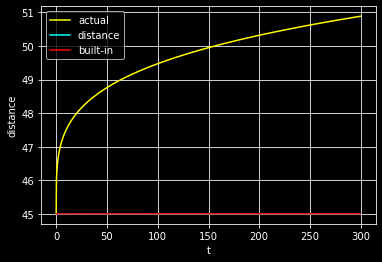

In [29]:
a = 0.0# start time
b = 300.0  # end time
N = 1000
h = (b-a)/N

mass_obj1 = 30
mass_obj2 = 60

def r_dot(r,t):
    #drdt = (-65/5)*(mass_obj1*mass_obj2*(mass_obj1+mass_obj2))/(r**3)
    drdt = 1/(r**3)
    return drdt

tpoints = np.arange(a,b,h)
r = np.zeros(N)
r[0] = 45 #np.linalg.norm(get_r(pos_obj1,pos_obj2))

# Loop over points to solve for r
#for i in range(N-1):
#    r[i+1] = r[i] + h*r_dot(r[i], tpoints[i])
    
for i in range(N-1):
    k1 = h*r_dot(r[i], tpoints[i])
    k2 = h*r_dot(r[i]+k1/2, tpoints[i]+h/2)
    k3 = h*r_dot(r[i]+k2/2, tpoints[i]+h/2)
    k4 = h*r_dot(r[i]+k3, tpoints[i]+h)
    r[i+1] = r[i] + (1/6)*(k1+2*k2+2*k3+k4)

actual = (4*tpoints)**(1/4) +r[0]
sol = odeint(r_dot,r[0],tpoints)

plt.plot(tpoints, actual, label='actual', c='yellow')
plt.plot(tpoints, r, label='distance', c='cyan')
plt.plot(tpoints,sol, label='built-in', c='red')
plt.xlabel("t")
plt.ylabel('distance')
plt.legend()
plt.show()

## From stackoverflow
https://stackoverflow.com/questions/71415925/python-euler-integration-method-for-two-body-system-not-producing-correct-plot

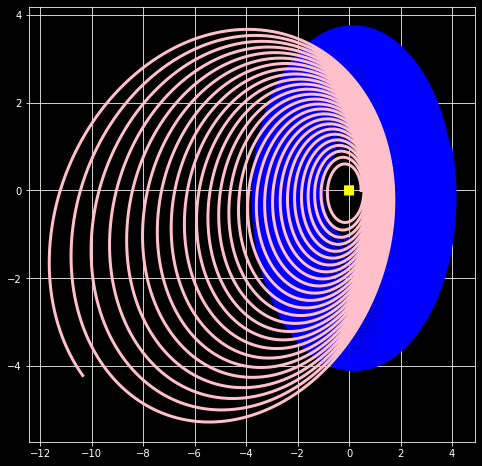

In [99]:
aEarth = 1 #semi-major axis (AU)
eEarth = 0.0167 #eccentricity (no units)

aMercury = 0.387098 #semi-major axis (AU)
eMercury = 0.205635 #eccentricity (no units)
    
Msun = 1 #Mass of Sun (Solar Mass)
Mearth = 3.0024584*10**(-6) #Mass of Earth (Solar Mass)
Mmercury = 1.65956463*10**(-7) #Mass of Mercury (Solar Mass)
Mes = (Msun + Mearth)
Mms = (Msun + Mmercury)
G = 1 #Gravitational Constant 

apocentreEarth = (aEarth*(1 + eEarth))
apocentreMercury = (aMercury*(1 + eMercury))

vapocentreEarth = (np.sqrt((G*(Mearth+Msun)/aEarth)*((1-eEarth)/(1+eEarth))))
vapocentreMercury = (np.sqrt((G*(Mmercury+Msun)/aMercury)*(1-eMercury/1+eMercury)))

xEarth = apocentreEarth
yEarth = 0.0
zEarth = 0.0

vxEarth = 0.0
vyEarth =(vapocentreEarth)
vzEarth = 0.0

xMercury = apocentreMercury
yMercury = 0.0
zMercury = 0.0

vxMercury = 0.0
vyMercury =(vapocentreMercury)
vzMercury = 0.0

class CelBody(object):
    # Constants of nature
    def __init__(self, id, name, x0, v0, mass, color, lw):
        # Name of the body (string)
        self.id = id
        self.name = name
        # Mass of the body (solar mass)
        self.M = mass
        # Initial position of the body (au)
        self.x0 = np.asarray(x0, dtype=float)
        # Position (au). Set to initial value.
        self.x = self.x0.copy()
        # Initial velocity of the body (au/s)
        self.v0 = np.asarray(v0, dtype=float)
        # Velocity (au/s). Set to initial value.
        self.v = self.v0.copy()
        self.a = np.zeros([3], dtype=float)
        self.color = color
        self.lw = lw

# All Celestial Objects

t = 0
dt = 0.01

Bodies = [
    CelBody(0, 'Sun', [0, 0, 0], [0, 0, 0], Msun, 'yellow', 10),
    CelBody(1, 'Earth', [xEarth, yEarth, zEarth], [vxEarth, vyEarth, vzEarth], Mearth, 'blue', 3),
    CelBody(2, 'Mercury', [xMercury, yMercury, zMercury], [ vxMercury, vyMercury, vzMercury], Mmercury, 'pink', 3),
    ]

paths = [ [ b.x[:2].copy() ] for b in Bodies]

# loop over ten astronomical years
v = 0
for t in range(0,100000):
    # compute forces/accelerations
    for body in Bodies:
        body.a *= 0
        for other in Bodies:
            # no force on itself
            if (body == other): continue # jump to next loop
            rx = body.x - other.x
            r3 = (np.sqrt(rx[0]**2+rx[1]**2+rx[2]**2))**3
            body.a += -G*other.M*rx/r3

    for n, planet in enumerate(Bodies):
        # use the Forward Euler algorithm 
        #planet.a = -G*other.M*rx/r3
        planet.x += planet.v*dt
        planet.v += planet.a*dt
        paths[n].append( planet.x[:2].copy() )
        #print("%10s x:%53s v:%53s"%(planet.name,planet.x, planet.v))


plt.figure(figsize=(8,8))
for n, planet in enumerate(Bodies): 
    px, py=np.array(paths[n]).T; 
    plt.plot(px, py, color=planet.color, lw=planet.lw)
plt.show()

In [100]:
px.shape

(100001,)

In [107]:
vapocentreMercury

1.6072727153545499

In [32]:
Msun = 1 #Mass of Sun (Solar Mass)
m1 = myNS.get_mass()*Ms
m2 = myNS2.get_mass()*Ms
M = (m1 + m2)

r1 = np.array([d,0,0])
r2 = np.array([0,0,0])
v1 = np.array([0, ev, 0])
v2 = np.array([0, -1*ev, 0])

class CelBody(object):
    # Constants of nature
    def __init__(self, id, ns, name, x0, v0, m, color, lw):
        # Name of the body (string)
        self.id = id
        self.ns = ns
        self.name = name
        # Mass of the body (solar mass)
        self.M = m
        # Initial position of the body (au)
        self.x0 = np.asarray(x0, dtype=float)
        # Position (au). Set to initial value.
        self.x = self.x0.copy()
        # Initial velocity of the body (au/s)
        self.v0 = np.asarray(v0, dtype=float)
        # Velocity (au/s). Set to initial value.
        self.v = self.v0.copy()
        self.a = np.zeros([3], dtype=float)
        self.color = color
        self.lw = lw

# All Celestial Objects

t = 0
dt = 3000

Bodies = [
    CelBody(0, myNS, 'one', r1, v1, m1, 'yellow', 4),
    CelBody(1, myNS2, 'two', r2, v2, m2, 'blue', 3),
    ]

paths = [ [ b.x[:2].copy() ] for b in Bodies]

# loop over ten astronomical years
v = 0

In [35]:
for t in range(0,35000):
    # compute forces/accelerations
    for body in Bodies:
        body.a *= 0
        for other in Bodies:
            # no force on itself
            if (body == other): continue # jump to next loop
            rx = body.x - other.x
            r3 = (np.sqrt(rx[0]**2+rx[1]**2+rx[2]**2))**3
            body.a += -G*other.M*rx/r3

    for n, planet in enumerate(Bodies):
        # use the Forward Euler algorithm 
        planet.x += planet.v*dt
        planet.v += planet.a*dt
        paths[n].append( planet.x[:2].copy() )

In [47]:
np.zeros([2,2])

array([[0., 0.],
       [0., 0.]])

In [23]:
class CelBody(object):
    # Constants of nature
    def __init__(self, id, ns, name, x0, v0, m):
        # Name of the body (string)
        self.id = id
        self.ns = ns
        self.name = name
        # Mass of the body (solar mass)
        self.M = m
        # Initial position of the body (au)
        self.x0 = np.asarray(x0, dtype=float)
        # Position (au). Set to initial value.
        self.x = self.x0.copy()
        # Initial velocity of the body (au/s)
        self.v0 = np.asarray(v0, dtype=float)
        # Velocity (au/s). Set to initial value.
        self.v = self.v0.copy()
        self.a = np.zeros([3], dtype=float)


# THIS FUNCTION IS 2D!!
def fw_euler(ns1, ns2, r1, r2, v1, v2, N, dt):
    m1 = ns1.get_mass()*Ms
    m2 = ns2.get_mass()*Ms
    M = (m1 + m2)
    Bodies = [
        CelBody(0, ns1, 'one', r1, v1, m1),
        CelBody(1, ns2, 'two', r2, v2, m2),
        ]

    paths = [ [ b.x[:2].copy() ] for b in Bodies]

    for t in range(0,N):
        # compute forces/accelerations
        for body in Bodies:
            body.a *= 0
            for other in Bodies:
                # no force on itself
                if (body == other): continue # jump to next loop
                rx = body.x - other.x
                r3 = (np.sqrt(rx[0]**2+rx[1]**2+rx[2]**2))**3
                body.a += -G*other.M*rx/r3

        for n, planet in enumerate(Bodies):
            # use the Forward Euler algorithm 
            planet.x += planet.v*dt
            planet.v += planet.a*dt
            paths[n].append( planet.x[:2].copy() )
        
    p1 = np.zeros([N,2])
    p2 = np.zeros([N,2])
        
    for planet in enumerate(Bodies): 
        p1=np.array(paths[0])
        p2=np.array(paths[1])
    
    return p1, p2

In [24]:
r1 = np.array([d,0,0])
r2 = np.array([0,0,0])
v1 = np.array([0, ev, 0])
v2 = np.array([0, -1*ev, 0])
N = 35000
dt = 3000

p1, p2 = fw_euler(myNS, myNS2, r1, r2, v1, v2, N, dt)

In [25]:
p1[:,0]

array([1.50000000e+11, 1.50000000e+11, 1.49999894e+11, ...,
       1.43983070e+11, 1.44021851e+11, 1.44060546e+11])

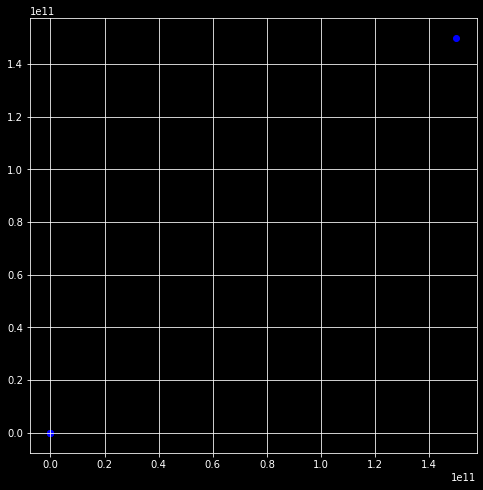

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(p1[0], p1[1], c='blue')
plt.scatter(p2[0], p2[1], c='blue')
plt.show()

0
1


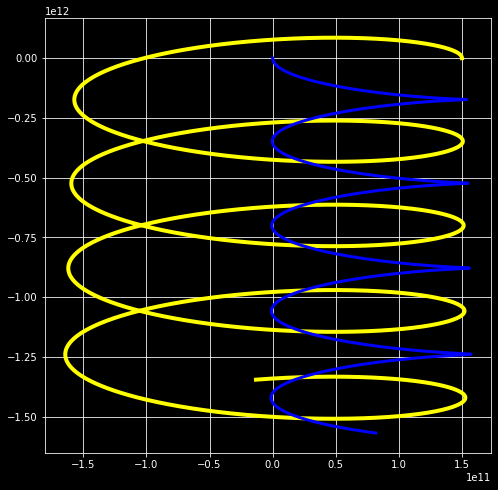

In [48]:
plt.figure(figsize=(8,8))
for n, planet in enumerate(Bodies):
    px, py=np.array(paths[n]).T; 
    plt.plot(px, py, color=planet.color, lw=planet.lw)
plt.show()

## Stack 2
https://stackoverflow.com/questions/57253590/plot-orbit-of-two-body-using-rk4

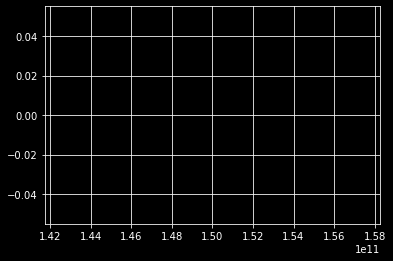

In [131]:
def accelerations(earthpos, sunpos):
    norme=sum( (earthpos-sunpos)**2 )**0.5
    gravit = G*(earthpos-sunpos)/norme**3
    suna = me*gravit
    eartha = -ms*gravit
    return eartha, suna

AU=1.5e11
a=AU  #semi major axis
e=0.1 #eccentricity
ms = 2e30
me = 5.98E24
h=10**(-6) 
G=6.67e-11
step=600 #timestep

sunpos=np.array([0,0,0])
earthpos=np.array([a,0,0])

earthv=np.array([0,35000,0])
sunv=np.array([0,-35000,0])

norme=np.sqrt(abs(earthpos[0]**2+earthpos[1]**2+earthpos[2]**2-sunpos[0]**2+sunpos[1]**2+sunpos[2]**2))
norma=np.sqrt(abs(-(earthpos[0]**2+earthpos[1]**2+earthpos[2]**2)+(sunpos[0]**2+sunpos[1]**2+sunpos[2]**2)))

eartha=G*ms*(earthpos-sunpos)/norme**3
suna=G*me*(sunpos-earthpos)/norma**3

xarray=[]
yarray=[]
zarray=[]
xarray.append(earthpos[0])
yarray.append(earthpos[1])
zarray.append(earthpos[2])

t=0
T=10**4
while t<T:
    eartha, suna = accelerations(earthpos, sunpos)
    k1v1 = h*earthv
    k1v2=h*sunv
    k1a1=h*eartha
    k1a2=h*suna

    eartha, suna = accelerations(earthpos+0.5*k1v1, sunpos+0.5*k1v2)
    k2v1 = h*(earthv+0.5*k1a1)
    k2v2=h*(sunv+0.5*k1a2)
    k2a1=h*eartha
    k2a2=h*suna

    eartha, suna = accelerations(earthpos+0.5*k2v1, sunpos+0.5*k2v2)
    k3v1 = h*(earthv+0.5*k2a1)
    k3v2=h*(sunv+0.5*k2a2)
    k3a1=h*eartha
    k3a2=h*suna
    
    eartha, suna = accelerations(earthpos+k3v1, sunpos+k3v2)
    k4v1 = h*(earthv+k3a1)
    k4v2=h*(sunv+k3a2)
    k4a1=h*eartha
    k4a2=h*suna
    
    xarray.append(earthpos[0])
    yarray.append(earthpos[1])
    zarray.append(earthpos[2])

    t=t+step

plt.plot(xarray,yarray,c='yellow')

In [130]:
xarray

[150000000000.0, 150000000000.0, 150000000000.0]

## Glowscript 2
https://trinket.io/glowscript/065d41f97d

In [191]:
12*60*60

43200

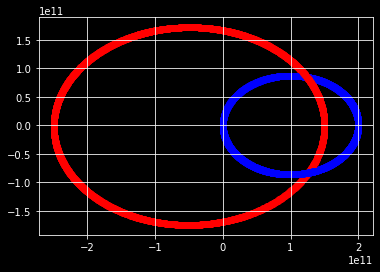

In [192]:
G = 6.7e-11
d = 1.5e11
p1 = np.array([d,0,0])
m1 = 1e30
p2 = np.array([0,0,0])
m2 = 2*m1

# make elliptical orbit in xz plane
ev = (2*3.14159*d/(365*24*60*60)) 
mom1 = np.array([0, m1*ev, 0])
mom2 = -1*mom1
dt = 12*60*60

# A in the xz plane
locationA = np.array([-0.4*d, 0, 0]) 

Lscale = 3.7e-35
pscale = 4e-24

fig, ax = plt.subplots()

t = 0
tend = 90000000

while t<tend:
    r = p2-p1
    F = -(G*m2*m1*r/np.linalg.norm(r)**3)
    mom2 = mom2 + F*dt
    p2 = p2 + (mom2/m2)*dt
    mom1 = mom1 - F*dt
    p1 = p1 + (mom1/m1)*dt
    plt.scatter(p1[0],p1[1],c='red')
    plt.scatter(p2[0],p2[1],c='blue')
    t = t+dt

In [200]:
12*60*60

43200

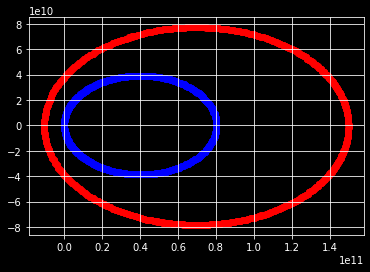

In [5]:
G = 6.7e-11
Ms = 1.98847e30 # solar mass in kg

d = 1.5e11
p1 = np.array([d,0,0])
m1 = myNS.get_mass()*Ms
p2 = np.array([0,0,0])
m2 = myNS2.get_mass()*Ms

# make elliptical orbit in xz plane
ev = (2*3.14159*d/(365*24*60*60)) 
mom1 = np.array([0, m1*ev, 0])
mom2 = -1*mom1
dt = 12*60*60

fig, ax = plt.subplots()

t = 0
tend = 1200

while t<tend:
    r = p2-p1
    F = -(G*m2*m1*r/np.linalg.norm(r)**3)
    mom2 = mom2 + F*dt
    p2 = p2 + (mom2/m2)*dt
    mom1 = mom1 - F*dt
    p1 = p1 + (mom1/m1)*dt
    plt.scatter(p1[0],p1[1],c='red')
    plt.scatter(p2[0],p2[1],c='blue')
    t = t+1

In [209]:
mom1

array([-6.79914677e+34,  2.14970639e+34,  0.00000000e+00])

In [210]:
l = np.zeros([tend+1,3])
l.shape

(2201, 3)

In [7]:
p1, p2 = orbit(myNS,myNS2)

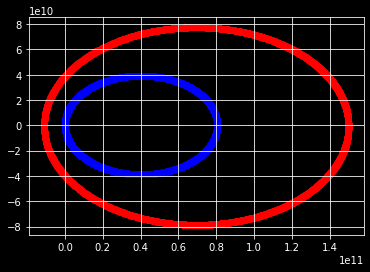

In [8]:
fig, ax = plt.subplots()
plt.scatter(p1[:,0],p1[:,1],c='red')
plt.scatter(p2[:,0],p2[:,1],c='blue')

29885.749619482496

29885.749619482496

## leapfrog test

In [18]:
d = 1.5e11
ev = (2*3.14159*d/(365*24*60*60)) 

x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2 = leapfrogintegrate(np.array([d,0,0]), np.array([0,0,0]), np.array([0, ev, 0]), np.array([0, -1*ev, 0]), myNS.get_mass()*Ms, myNS2.get_mass()*Ms, N=35000, dt=2500)


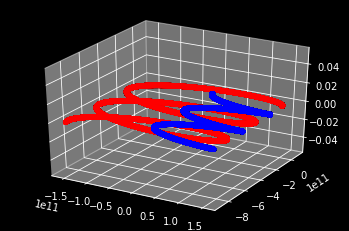

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(x1[:], y1[:], z1[:], c='red')
ax.scatter(x2[:], y2[:], z2[:], c='blue')

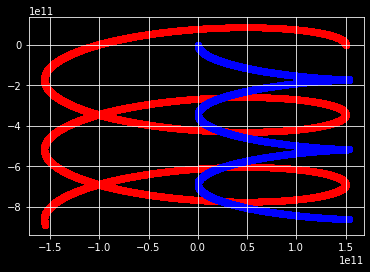

In [20]:
fig, ax = plt.subplots()
ax.scatter(x1[:], y1[:], c='red')
ax.scatter(x2[:], y2[:], c='blue')

## drag to leapfrog 

Uses page 5 of http://www.tapir.caltech.edu/~chirata/ph236/2011-12/lec15.pdf

In [32]:
np.array([0, ev, 0]) - grav_drag(myNS.get_mass(), myNS2.get_mass(), 3e3)

array([3.16049383e-16, 2.98857496e+04, 3.16049383e-16])

In [302]:
def grav_drag(m1, m2, r):
    #rdot = (-64/5)*(m1*m2*(m1+m2))/(np.linalg.norm(r)**5)
    rdot = (-0.005)*(m1*m2*(m1+m2))*r/(np.linalg.norm(r)**6)
    return rdot

def leapfrogintegrate_drag(pos1, pos2, vel1, vel2, mass1, mass2, N=35000, dt=2000):
    # pos1 = [x,y,z] array
    # pos2 = [x,y,z] array
    # vel1 = [x,y,z] array
    # vel2 = [x,y,z] array
    
    # does leapfrog integration and returns position and velocity values 
    
    # Create empty arrays 

    p1 = np.zeros([N,3])
    p2 = np.zeros([N,3])
    v1 = np.zeros([N,3])
    v2 = np.zeros([N,3])
    
    # initialize 
    for index in range(N):
        # set initial step 
        if index == 0:
            p1[0] = pos1
            p2[0] = pos2
            v1[0] = vel1
            v2[0] = vel2
        # integrate 
        else:
            r = get_r(p1[index-1], p2[index-1])
            if index >= N-4:
                print(np.linalg.norm(r))
            if np.linalg.norm(r) < 409: #28579265:
                gwdrag = 0
                F = grav_force(mass1, mass2, r)*100
                print(F)
                if v1[index-1] <= 0:
                    v1[index] = v1[index-1]-dt*F/mass1 
                else:
                    v1[index] = v1[index-1]+dt*F/mass1
                v2[index] = v2[index-1]+dt*F/mass2
                
            else:
                gwdrag = grav_drag(mass1,mass2, r)
                F = grav_force(mass1, mass2, r)
                # sets next velocity. 
                # uses the particle's acceleration, last jump, and grav force
                v1[index] = v1[index-1]-dt*F/mass1 
                v2[index] = v2[index-1]+dt*F/mass2

            # sets next position. 
            # uses the last jump and next velocity 
            p1[index] = p1[index-1]+dt*(v1[index]+gwdrag/mass1)
            p2[index] = p2[index-1]+dt*(v2[index]+gwdrag/mass2)
    
    return p1,p2,v1,v2

In [7]:
n = 17800
p1,p2,v1,v2 = leapfrogintegrate_drag(np.array([d,0,0]), np.array([0,0,0]), np.array([0, ev, 0]), np.array([0, -1*ev, 0]), myNS.get_mass()*Ms, myNS2.get_mass()*Ms, N=n, dt=5000)


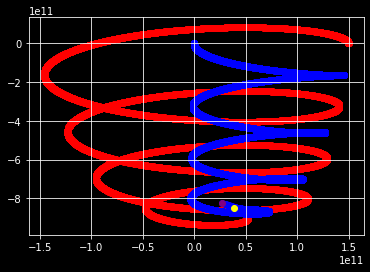

In [312]:
fig, ax = plt.subplots()
ax.scatter(pos1[:,0], pos1[:,1], c='red')
ax.scatter(pos2[:,0], pos2[:,1], c='blue')

ax.scatter(pos1[n-1,0], pos1[n-1,1], c='yellow')
ax.scatter(pos2[n-1,0], pos2[n-1,1], c='purple')

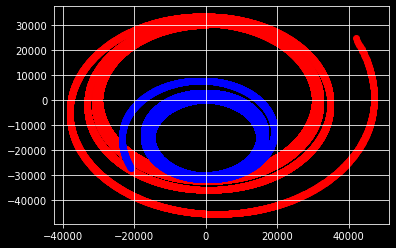

In [298]:
fig, ax = plt.subplots()
ax.scatter(v1[:,0], v1[:,1], c='red')
ax.scatter(v2[:,0], v2[:,1], c='blue')

In [ ]:
plt.plot(pos1[:,0])

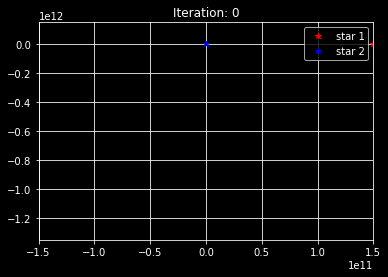

In [8]:
fig,ax = plt.subplots()
plot1, = ax.plot(p1[0,0],p1[0,1], linestyle="", marker="*",color='red', label='star 1')
plot2, = ax.plot(p2[0,0],p2[0,1], linestyle="", marker="*",color='blue', label='star 2')
ax.legend()

def animate(i):
    plot1.set_ydata(p1[i,1])
    plot1.set_xdata(p1[i,0])
    plot2.set_ydata(p2[i,1])
    plot2.set_xdata(p2[i,0])
    plt.title("Iteration: " + str(i))
    ax.set_xlim([-d, d])
    ax.set_ylim([-9*d, d])

ani = animation.FuncAnimation(fig, animate, interval=5, frames=len(p1))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(p1)):
    ax.scatter(p1[i][0], p1[i][1], c='red')
    ax.scatter(p2[i][0], p2[i][1], c='blue')

plt.show()

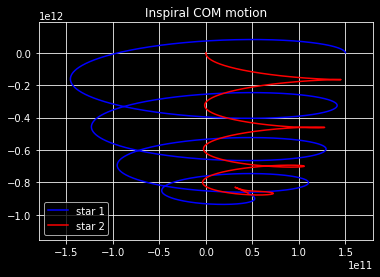

In [19]:
plt.plot(p1[:,0], p1[:,1], c='blue', label='star 1')
plt.plot(p2[:,0], p2[:,1], c='red', label='star 2')
plt.title('Inspiral COM motion')
plt.xlim([-d-d/5, d+d/5])
plt.ylim([-7.7*d, d+d/4])
plt.legend()